<a href="https://colab.research.google.com/github/lustea0201/Underdogs/blob/master/Final_project/Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the training dataset


In [104]:
!rm -rf data.zip # Delete the previously loaded file 

import zipfile
import os 

from google.colab import drive
drive.mount('/content/drive/') # Link the drive account to import a zip 

data = zipfile.ZipFile("/content/drive/My Drive/Super Resolution/data.zip", 'r') # REPLACE path

data.extractall()
data.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os 
from torchvision.datasets import ImageFolder
from torchvision import transforms


In [0]:
# Need to rename all files so that they are loaded in numerical order
for shape in ["irregular", "circle"]: 
  for number in ["1", "16", "32", "64"]: 
    base_h = "/content/data/" + shape + "_" + number + "/High/Images/"
    base_l = "/content/data/" + shape + "_" + number + "/Low/Images/"
    if shape == "circle": 
      base_h += "Circle_" + number + "_"
      base_l += "Circle_" + number + "_"
    else:
      base_h += "Irregular_" + number + "_"
      base_l += "Irregular_" + number + "_"
    for i in range(1,201): 
      src = base_h + str(i) + ".tif"
      drt = "/content/data/" + shape + "_" + number + "/High/Images/" + str(i).zfill(3) + ".tif"
      os.rename(src,drt)
      src = base_l + str(i) + ".tif"
      drt = "/content/data/" + shape + "_" + number + "/Low/Images/" + str(i).zfill(3) + ".tif"
      os.rename(src,drt)

In [0]:
import torch
batch_train, batch_val = 8, 1 # batch size has to be 1 for validation so PSNR formula is correct
N_augmentation = 8 # For training, the images will be augmented 8 times 

train, test, val  = [], [], []

N_test, N_train, N_val = 30, 70, 20



for s in ["circle","irregular"]:
  for n in ["32","1","64", "16"]: 
    X_t = ImageFolder(root = "/content/data/" + s + "_" + n + "/Low", transform = transforms.ToTensor()) # Load images in the folder as torch tensors
    Y_t = ImageFolder(root = "/content/data/" + s + "_" + n + "/High", transform = transforms.ToTensor())
      
    for i in range(N_test, N_train+N_test):
      train.append([X_t[i][0],Y_t[i][0]]) # Add the tuple low-high definition in the training set

train_loader = torch.utils.data.DataLoader(train, shuffle=True, batch_size = batch_train) # Build a dataloader for training
del train # free RAM 

for s in ["circle","irregular"]:
  for n in ["32","1","64", "16"]: 
    X_t = ImageFolder(root = "/content/data/" + s + "_" + n + "/Low", transform = transforms.ToTensor())
    Y_t = ImageFolder(root = "/content/data/" + s + "_" + n + "/High", transform = transforms.ToTensor())
    for i in range(N_train+N_test, N_train+N_test+N_val):
      val.append([X_t[i][0],Y_t[i][0]])



val_loader = torch.utils.data.DataLoader(val, shuffle=True, batch_size = batch_val)
del val 




In [0]:

import matplotlib.pyplot as plt

def display_batch_first(xx): 
  plt.figure(figsize=(5, 5))
  plt.imshow(xx[0].permute(1,2,0))

def augment_batch(xx, yy): 
  # xx is a low definition image, yy the corresponding high definition image 
  # returns a tensor with 8 times each of these, rotated and flipped
  sx = xx.shape
  augmented_x = torch.Tensor(size = [8*sx[0],sx[1],sx[2], sx[3]])
  sy = yy.shape
  augmented_y = torch.Tensor(size = [8*sy[0],sy[1],sy[2], sy[3]])
  for i in range(sx[0]): 
    augmented_x[8*i] = xx[i]
    augmented_x[8*i+1] = xx[i].rot90(1, dims=[1,2])
    augmented_x[8*i+2] = xx[i].rot90(2, dims=[1,2])
    augmented_x[8*i+3] = xx[i].rot90(3, dims=[1,2])
    augmented_x[8*i+4] = xx[i].permute(0,2,1)
    augmented_x[8*i+5] = xx[i].rot90(1, dims=[1,2]).permute(0,2,1)
    augmented_x[8*i+6] = xx[i].rot90(2, dims=[1,2]).permute(0,2,1)
    augmented_x[8*i+7] = xx[i].rot90(3, dims=[1,2]).permute(0,2,1)

    augmented_y[8*i] = yy[i]
    augmented_y[8*i+1] = yy[i].rot90(1, dims=[1,2])
    augmented_y[8*i+2] = yy[i].rot90(2, dims=[1,2])
    augmented_y[8*i+3] = yy[i].rot90(3, dims=[1,2])
    augmented_y[8*i+4] = yy[i].permute(0,2,1)
    augmented_y[8*i+5] = yy[i].rot90(1, dims=[1,2]).permute(0,2,1)
    augmented_y[8*i+6] = yy[i].rot90(2, dims=[1,2]).permute(0,2,1)
    augmented_y[8*i+7] = yy[i].rot90(3, dims=[1,2]).permute(0,2,1)

  return augmented_x, augmented_y

def inspect_augmented_batch(axx): 
  f, axs = plt.subplots(1, 8, figsize=(30, 8*30))
  for i in range(8): 
    axs[i].imshow(axx[i].permute(1,2,0))

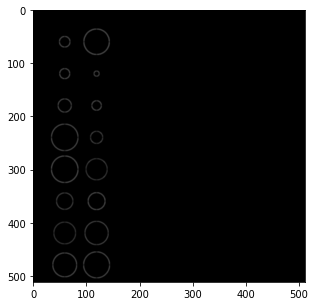

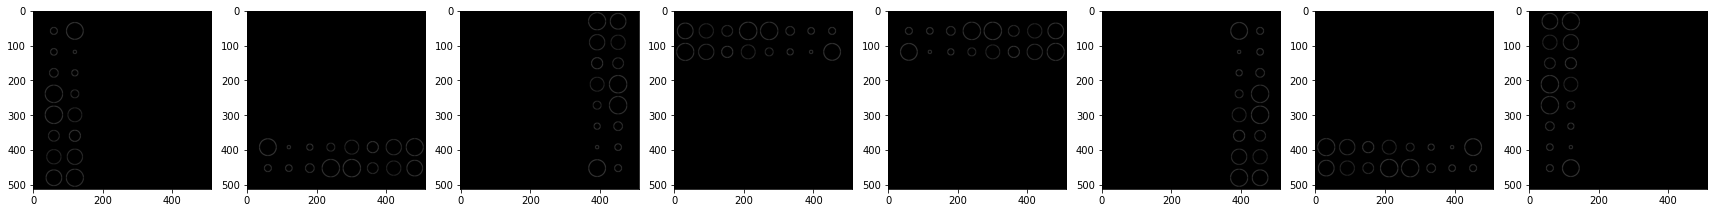

In [109]:
X, Y = next(iter(train_loader))
display_batch_first(X)
ax, ay = augment_batch(X,Y)
inspect_augmented_batch(ax)

(-0.5, 1023.5, 1023.5, -0.5)

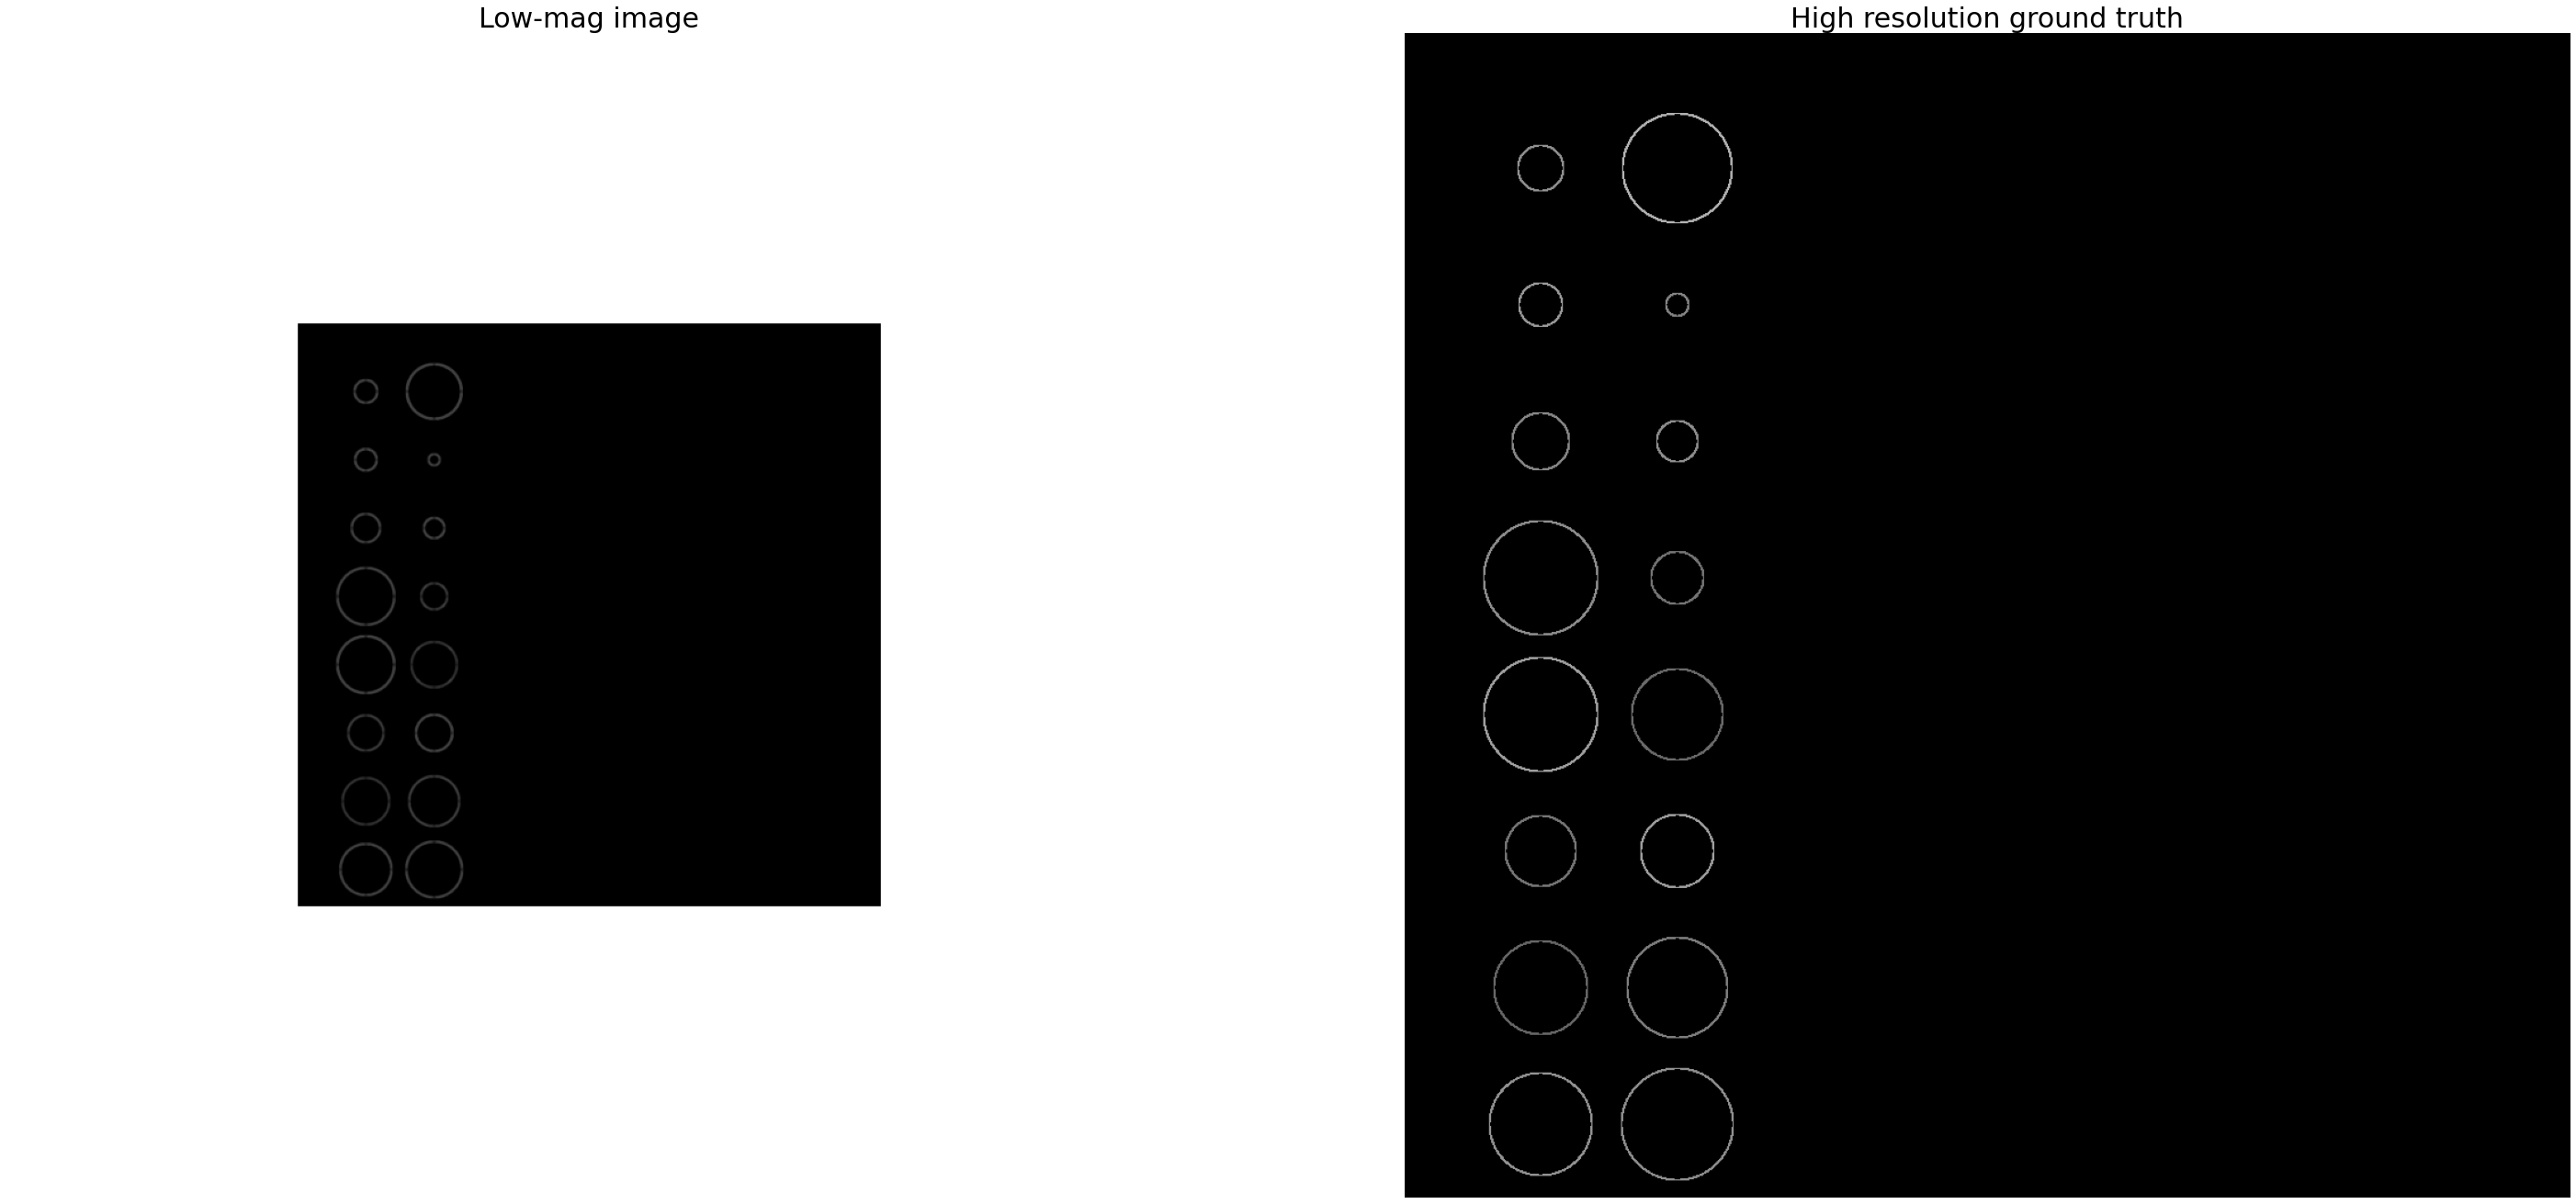

In [110]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1,2, figsize=(50,25))
im_h = Y[0].permute(1, 2, 0) # Because the convention is different in pytorch than matplotlib
im_l = torch.ones(im_h.shape) 
height = im_h.shape[0]
width = im_h.shape[1]
im_l[height//4:height-height//4, width//4:width-width//4, :] = X[0].permute(1,2,0)


axes[0].imshow(im_l)
axes[0].set_title("Low-mag image", fontsize=30);
axes[0].axis('off')
axes[1].imshow(im_h)
axes[1].set_title("High resolution ground truth", fontsize=30);
axes[1].axis('off')


In [0]:
import torch.nn as nn
import torch.nn.init as init


class Net(nn.Module):
    def __init__(self, upscale_factor): # Upscale factor will be 2 in our case
        super(Net, self).__init__() # Initialize super class
        self.relu = nn.ReLU() # Activation function 
        self.conv1 = nn.Conv2d(3, 32, (5, 5), (1, 1), (2, 2)) # parameters are: channels in, channels out, filter size, stride, padding (zero-padding to conserve image size)
        self.conv2 = nn.Conv2d(32, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, 3*upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor) # This will redistribute all pixels across patches to form one high dimensional image
        self._initialize_weights()

    def forward(self, x): # forward propagation 
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        x = self.pixel_shuffle(x)
        return x

    def _initialize_weights(self): # initializing weights of network parameters 
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)




In [0]:
import matplotlib.pyplot as plt 
import numpy as np

def compare(p,t, gen):  # compare prediction to ground truth. gen is the epoch number
  fig, axes = plt.subplots(1,2, figsize=(30,15))

  p = p.cpu().detach()
  t = t.cpu().detach()
  p = (255*p.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[0].imshow(p)
  axes[0].set_title("Prediction (generation %d)" %gen, fontsize=30);
  axes[0].axis('off')

  t = (255*t.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[1].imshow(t)
  axes[1].set_title("High resolution ground truth", fontsize=30);
  axes[1].axis('off')
  plt.show()

In [0]:
import torch.optim as optim
from math import log10



torch.manual_seed(12)

device = torch.device("cuda") # To allow GPU use. Please go to Edit>Notebook Settings> GPU to use Colab's GPU

model = Net(upscale_factor=2).to(device) # Initializing the neural network and passing it to GPU
criterion = nn.MSELoss() # Mean squared error will be the loss function. 

optimizer = optim.Adam(model.parameters(), lr=0.003) # Using the Ada optimizer. Unfortunately, I canno't add a penalty term as this would make the PSNR computation wrong. 

In [0]:

loss_constant = 10000 # To multiply the loss to get a comprehensible number 
augment = True 

def train(epoch):
    show = False # For debugging 
    def act(): # does backpropagation and returns loss 
      optimizer.zero_grad()
      pred = model(input_)
      loss = criterion(pred, target)
      delta = loss.item()
      loss.backward()
      optimizer.step()
      return delta

    epoch_loss = 0
    for iteration, batch in enumerate(train_loader, 1):
        
        input_, target = batch[0].to(device), batch[1].to(device) # Move batch to GPU
        optimizer.zero_grad() # Set gradient to before processing batch  
        pred = model(input_) # Predict high res images
        loss = criterion(pred, target) # Compute loss of batch 
        epoch_loss += loss.item() # Add to epoch loss
        loss.backward() # Backpropagation 
        optimizer.step() # Modify network parameters 

        if show: display_batch_first(input_.cpu())

        if augment: 
          # Turned 90 degrees
          input_ = input_.rot90(1, dims=[2,3])
          if show: display_batch_first(input_.cpu())
          target = target.rot90(1, dims=[2,3])
          epoch_loss += act()
          # Turned 180 degrees
          input_ = input_.rot90(1, dims=[2,3])
          if show: display_batch_first(input_.cpu())
          target = target.rot90(1, dims=[2,3])
          epoch_loss += act()
          # Turned 270 degrees
          input_ = input_.rot90(1, dims=[2,3])
          if show: display_batch_first(input_.cpu())
          target = target.rot90(1, dims=[2,3])
          epoch_loss += act()
          # Turned 270 degrees and flipped 
          input_ = input_.permute(0,1,3,2)
          if show: display_batch_first(input_.cpu())
          target = target.permute(0,1,3,2)
          epoch_loss += act()
          # Turned 180 degrees and flipped 
          input_ = input_.rot90(1, dims=[2,3])
          if show: display_batch_first(input_.cpu())
          target = target.rot90(1, dims=[2,3])
          epoch_loss += act()
          # Turned 90 degrees and flipped 
          input_ = input_.rot90(1, dims=[2,3])
          if show: display_batch_first(input_.cpu())
          target = target.rot90(1, dims=[2,3])
          epoch_loss += act()
          # Flipped 
          input_ = input_.rot90(1, dims=[2,3])
          if show: display_batch_first(input_.cpu())
          target = target.rot90(1, dims=[2,3])
          epoch_loss += act()
        
        show = False
      

    if epoch % 10 == 1: # Every 10 generations, show an example of prediction
      if augment: 
        target = target.permute(0,1,3,2)
      compare(pred[0], target[0], epoch)
    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, loss_constant*epoch_loss / (len(train_loader)*N_augmentation*batch_train)))
    return loss_constant*epoch_loss / (len(train_loader)*N_augmentation*batch_train)


def validate(): # Compute the loss on validation set to monitor overfitting, and compute average PSNR on unseen images. 
    avg_psnr = 0
    loss_epoch = 0
    with torch.no_grad():
        for batch in val_loader:
            
            input_, target = batch[0].to(device), batch[1].to(device)
            prediction = model(input_)
            mse = criterion(prediction, target)
            loss_epoch += mse
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr

    PSNR = avg_psnr / (len(val_loader)*batch_val)
    loss = loss_constant*loss_epoch/(len(val_loader)*batch_val)

    print("===> Avg. PSNR: {:.4f} dB".format(PSNR))
    print("Validation loss: %.3f" %(loss))
    return loss, PSNR


t_loss, v_loss, v_psnr = [], [], []
for epoch in range(1, 2):
    t_loss.append(train(epoch))
    l, p = validate()
    v_loss.append(l)
    v_psnr.append(p)



In [0]:
plt.plot(v_loss)
plt.plot(t_loss)
plt.legend(["val", "train"])

In [0]:
plt.plot(v_psnr)

In [0]:
#save = input("Overwrite current state dictionnary ? [y/n]")
save = 'y'
if (save == 'y'): 
  torch.save(model.state_dict(), 'drive/My Drive/Super Resolution/model_50dB.pth') # Save the trained neural net so it can be used to make predictions
  print("State dictionnary saved.")
else: 
  print("State dictionnary has not been saved.")